In [80]:
!pip install umap-learn

In [156]:
import subprocess
import json
import matplotlib.pyplot as plt
import numpy as np
import csv
import seaborn as sns
import umap
from matplotlib import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [164]:
GT_file = "Vertebrata_GT.tsv"
sequence_file = "Vertebrata.fas"
n_epochs = 35
lambda_value = 2.8
n_voters = 5
k = 6
n_clusters = 5
n_mimics = 3
batch_sz = 512

In [165]:
command = f'./iDeLUCS/idelucs/__main__.py --sequence_file={sequence_file} --n_epochs={n_epochs} --n_voters={n_voters} --lambda={lambda_value} --k={k} --n_clusters={n_clusters} --n_mimics={n_mimics} --batch_sz={batch_sz}'

In [166]:
subprocess.run(['bash', '-c', command])


Training Parameters:
sequence_file 	 -> Vertebrata.fas
n_clusters 	 -> 5
n_epochs 	 -> 35
n_mimics 	 -> 3
batch_sz 	 -> 512
GT_file 	 -> None
k 	 -> 6
optimizer 	 -> RMSprop
scheduler 	 -> None
weight 	 -> 0.25
lambda 	 -> 2.8
lr 	 -> 0.001
n_voters 	 -> 5
model_size 	 -> linear
plot 	 -> False
None
No. Sequences: 	 2,500
Min. Length: 	 14,127
Max. Length: 	 24,317
Avg. Length: 	 16,929.48
........... Training Model (5/5)................

/home/jujukoko/.local/lib/python3.10/site-packages/idelucs/utils.py:588: RuntimeWarning: divide by zero encountered in divide
  D = 1.0 / euclidean_distances(features - _sums, cluster.cluster_centers_, squared=True)
/home/jujukoko/.local/lib/python3.10/site-packages/idelucs/utils.py:590: RuntimeWarning: invalid value encountered in divide
  D /= np.sum(D, axis=1)[:, np.newaxis]


........... Computing Results ................{'Davies-Boulding': 1.16665744380794, 'Silhouette-Score': 0.5242352591647227}
........ Saving Results ..............
hihi


CompletedProcess(args=['bash', '-c', './iDeLUCS/idelucs/__main__.py --sequence_file=Vertebrata.fas --n_epochs=35 --n_voters=5 --lambda=2.8 --k=6 --n_clusters=5 --n_mimics=3 --batch_sz=512'], returncode=0)

In [167]:
def latent_space_representation_umap(data,list_true,list_assign):
    umap_embedding = umap.UMAP(random_state=42).fit_transform(data)
    # get matching labels
    classes = [list_true[i][2] for i in range(len(list_true))]
    labels = [list_assign[i][1][1] for i in range(len(list_assign))]
    
    # Automatic generation of color based on the number of cluster
    num_classes = len(np.unique(classes))
    colors = plt.cm.tab10
    
    # draw points with generated color
    for i, c in enumerate(classes):
        plt.scatter(umap_embedding[i, 0], umap_embedding[i, 1], color=colors(c))
    
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.title('UMAP Projection')
    plt.show()

In [168]:
def dimension_reduction_pca(data, list_true, list_assign):
    pca = PCA(n_components=n_clusters, random_state=42)
    pca_embedding = pca.fit_transform(data)
    
    # get classes and corresponding labels
    classes = [list_true[i][2] for i in range(len(list_true))]
    labels = [list_assign[i][1][1] for i in range(len(list_assign))]
    
    # Automatic generation of color based on the number of cluster
    num_classes = len(np.unique(classes))
    colors = plt.cm.tab10
    
    # Draw the point with the corresponding color
    for i, c in enumerate(classes):
        plt.scatter(pca_embedding[i, 0], pca_embedding[i, 1], color=colors(c))
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA Projection')
    plt.show()

In [169]:
def read_file(input_file):
    res_list = []
    # Check the file extension
    if input_file.endswith('.csv') or input_file.endswith('.tsv'):
        # Read TSV file and return content as a list
        with open(input_file, 'r') as file:
            reader = csv.reader(file, delimiter='\t')  # Specify the delimiter as tab
            for row in reader:
                res_list.append(row)
    return res_list


In [198]:
def read_GT_file(input_file):
    # Read the GT input file
    list_true = read_file(input_file)
    list_true = list_true[1:]
    dico_name = {}
    indice = 0
    for elem in list_true:
        if elem[2] in dico_name:
            elem[2] = dico_name[elem[2]]
        else:
            dico_name[elem[2]]=indice
            elem[2]=indice
            indice+=1
    return list_true,dico_name

In [262]:
def normalize_tab(tab):
    dico_match={}
    new_tab = np.zeros((n_clusters, n_clusters))
    print(tab)
    for i in range(len(tab)):
        max = 0
        max_index = 0
        for j in range(len(tab[i])):
            if(tab[i][j]>max):
                max=tab[i][j]
                max_index = j
        dico_match[max_index]=i
    for i in range(len(tab)):
        j = 0
        for swap in range(len(dico_match)):
            new_tab[i][dico_match[swap]] = tab[i][j]
            j+=1
    return new_tab
            

In [263]:
def confusion_matrix(dico_predicted):
    if(GT_file != ""): #only if GT_file exist
        list_true,dico_name = read_GT_file(GT_file)
        #create an empty table
        tableau = np.zeros((n_clusters, n_clusters))
        for elem in list_true:
            true_cluster_id = elem[2]  # Remove [2] index
            sequence_id = elem[1]
            predicted_cluster_id = dico_predicted[sequence_id][1]
            tableau[int(true_cluster_id)][int(predicted_cluster_id)] += 1
        tableau = normalize_tab(tableau)
    return tableau,dico_name, list_true   
        

In [264]:
def print_confusion_matrix(tableau):
    fig, ax = plt.subplots()
    #color of the scale    
    cmap = colors.ListedColormap(['#F2F2F2', '#D3D3D3', '#A9A9D6', '#6B6BA9'])
    
    # Display of the confusion matrix
    im = ax.imshow(tableau, cmap=cmap)
    
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    # display cells values
    for i in range(len(tableau)):
        for j in range(len(tableau)):
            ax.text(j, i, int(tableau[i, j]), ha="center", va="center", color="black")
    
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted value")
    ax.set_ylabel("True value")
    
    cbar = ax.figure.colorbar(im, ax=ax)
    
    plt.show()

In [201]:
result_dict = {}

# Spécifiez le chemin du fichier de sortie
input_file = './tmp_file'


# Lisez le contenu du fichier JSON
with open(input_file, 'r') as file:
    result_dict = json.load(file)

[[  0.   0. 499.   1.   0.]
 [  0.   4.   0.   0. 496.]
 [  0.   5.   0. 495.   0.]
 [500.   0.   0.   0.   0.]
 [  0. 489.   0.   2.   9.]]


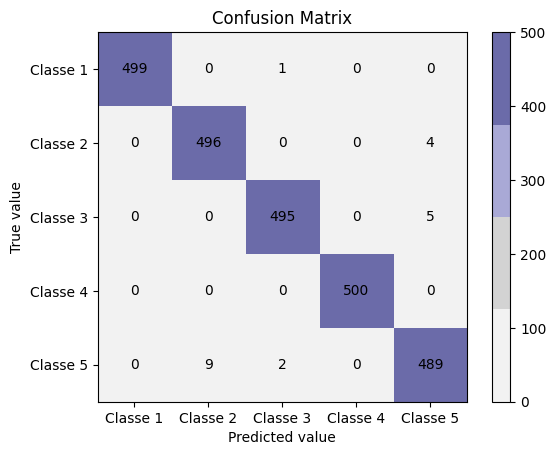

In [265]:
tableau,dico_name, list_true=confusion_matrix(result_dict['assignment'])
print_confusion_matrix(tableau)

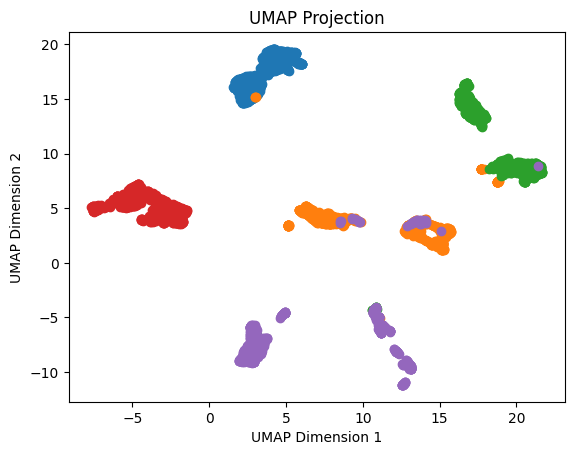

In [176]:
list_assign=list(result_dict['assignment'].items())
latent_space_representation_umap(result_dict['model_latent'],list_true,list_assign)

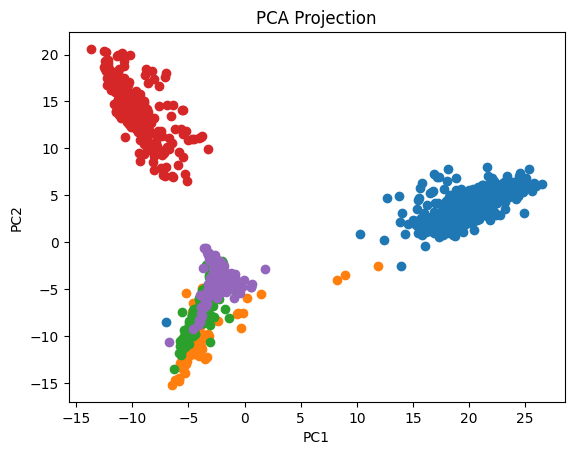

In [177]:
dimension_reduction_pca(result_dict['model_latent'],list_true,list_assign)

In [220]:
confusion_matrix_2(result_dict['assignment'])

0
NC_015897
2
